<br></br>
# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import json
from sklearn.utils._show_versions import show_versions
from threadpoolctl import threadpool_info

<br></br>
# Benchmark environment

In [2]:
with open("results/env_info.txt") as json_file:
    data = json.load(json_file)

print(json.dumps(data, indent=2))

{
  "system_info": {
    "python": "3.9.4 | packaged by conda-forge | (default, May 10 2021, 22:13:15)  [Clang 11.1.0 ]",
    "executable": "/Users/mathisbatoul/opt/miniconda3/envs/sklbench/bin/python",
    "machine": "macOS-11.4-x86_64-i386-64bit"
  },
  "dependencies_info": {
    "pip": "21.1.2",
    "setuptools": "49.6.0.post20210108",
    "sklearn": "1.0.dev0",
    "numpy": "1.20.3",
    "scipy": "1.6.3",
    "Cython": null,
    "pandas": "1.2.4",
    "matplotlib": "3.4.2",
    "joblib": "1.0.1",
    "threadpoolctl": "2.1.0"
  },
  "threadpool_info": [
    {
      "filepath": "/Users/mathisbatoul/opt/miniconda3/envs/sklbench/lib/libopenblasp-r0.3.15.dylib",
      "prefix": "libopenblas",
      "user_api": "blas",
      "internal_api": "openblas",
      "version": "0.3.15",
      "num_threads": 12,
      "threading_layer": "openmp"
    },
    {
      "filepath": "/Users/mathisbatoul/opt/miniconda3/envs/sklbench/lib/libomp.dylib",
      "prefix": "libomp",
      "user_api": "openmp",

# Gradient Boosting Classification Benchmarks

In [3]:
TIME_BUDGET = 300

In [4]:
df_skl = pd.read_csv("results/benchmarking/sklearn_HistGradientBoostingClassifier.csv")

In [5]:
df_lgbm = pd.read_csv("results/benchmarking/lightgbm_LGBMClassifier.csv")

In [6]:
df_xgb = pd.read_csv("results/benchmarking/xgboost_XGBClassifier.csv")

In [7]:
def compute_cumulated(fit_times, scores):
    cumulated_fit_times = fit_times.cumsum()
    best_val_score_so_far = pd.Series(scores).cummax()
    return cumulated_fit_times, best_val_score_so_far

In [8]:
fit_times_skl = df_skl[df_skl["function"] == "fit"]["mean_time"].values
fit_times_lgbm = df_lgbm[df_lgbm["function"] == "fit"]["mean_time"].values
fit_times_xgb = df_xgb[df_xgb["function"] == "fit"]["mean_time"].values
scores_skl = df_skl[df_skl["function"] == "predict"]["accuracy_score"].values
scores_lgbm = df_lgbm[df_lgbm["function"] == "predict"]["accuracy_score"].values
scores_xgb = df_xgb[df_xgb["function"] == "predict"]["accuracy_score"].values

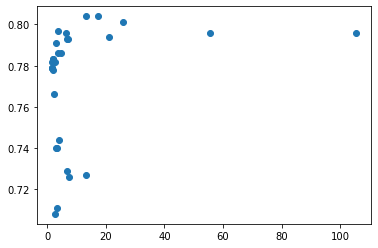

In [9]:
plt.scatter(fit_times_xgb, scores_xgb)

In [10]:
cumulated_fit_times_skl, best_val_score_so_far_skl = compute_cumulated(fit_times_skl, scores_skl)
cumulated_fit_times_lgbm, best_val_score_so_far_lgbm = compute_cumulated(fit_times_lgbm, scores_lgbm)
cumulated_fit_times_xgb, best_val_score_so_far_xgb = compute_cumulated(fit_times_xgb, scores_xgb)

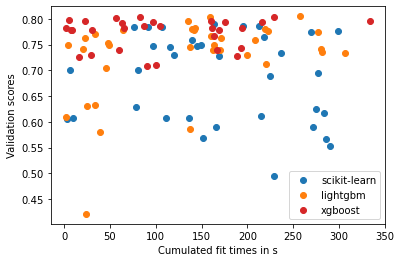

In [11]:
plt.scatter(cumulated_fit_times_skl, scores_skl, c="tab:blue", label="scikit-learn")
plt.scatter(cumulated_fit_times_lgbm, scores_lgbm, c="tab:orange", label="lightgbm")
plt.scatter(cumulated_fit_times_xgb, scores_xgb, c="tab:red", label="xgboost")
plt.xlabel("Cumulated fit times in s")
plt.ylabel("Validation scores")
plt.legend();

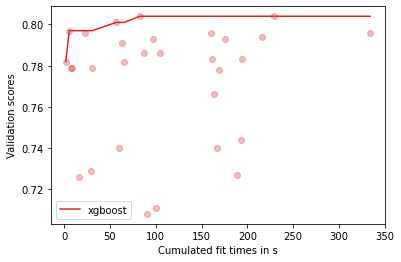

In [12]:
# plt.scatter(cumulated_fit_times_skl, scores_skl, c="tab:blue", alpha=0.3)
# plt.scatter(cumulated_fit_times_lgbm, scores_lgbm, c="tab:orange", alpha=0.3)
plt.scatter(cumulated_fit_times_xgb, scores_xgb, c="tab:red", alpha=0.3)

# plt.plot(cumulated_fit_times_skl, best_val_score_so_far_skl, c='tab:blue', label="scikit-learn")
# plt.plot(cumulated_fit_times_lgbm, best_val_score_so_far_lgbm, c='tab:orange', label="lightgbm")
plt.plot(cumulated_fit_times_xgb, best_val_score_so_far_xgb, c='tab:red', label="xgboost")

plt.xlabel("Cumulated fit times in s")
plt.ylabel("Validation scores")

plt.legend();

Text(0, 0.5, 'Validation scores')

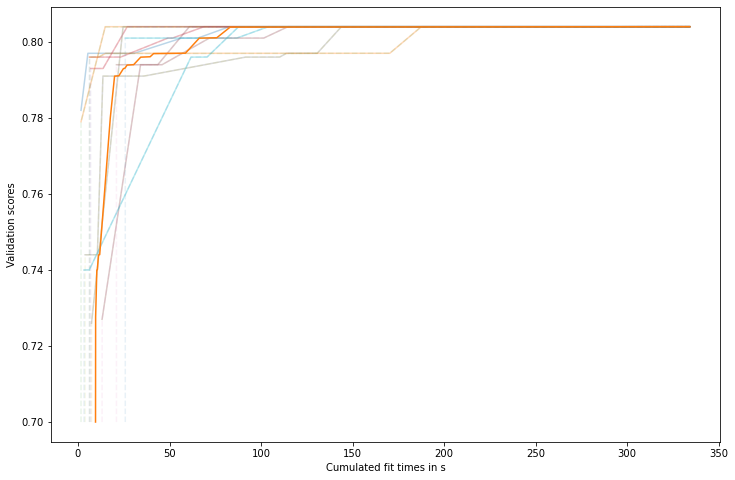

In [13]:
plt.figure(figsize=(12, 8))
grid_times = np.linspace(0, TIME_BUDGET, 1000)
cum_fit_times_xgb, cum_scores_xgb = compute_cumulated(fit_times_xgb, scores_xgb)
# plt.plot(cum_scores_xgb, cum_fit_times_xgb, label="original order", alpha=0.3)
plt.plot(cum_fit_times_xgb, cum_scores_xgb, label="original order", alpha=0.3)

baseline_score = 0.7
grid_scores = np.linspace(baseline_score, cum_scores_xgb.max(), 1000)
all_fit_times = []
rng = np.random.RandomState(0)

for i in range(10):
    indices = rng.permutation(fit_times_xgb.shape[0])
    cum_fit_times_xgb_p, cum_scores_xgb_p = compute_cumulated(fit_times_xgb[indices], scores_xgb[indices])
    grid_fit_times = np.interp(
        grid_scores,
        cum_scores_xgb_p,
        cum_fit_times_xgb_p,
#         left=0,
        right=cum_fit_times_xgb.max(),
    )
#     plt.plot(cum_fit_times_xgb_p, cum_scores_xgb_p, label=f"perm {i}", alpha=0.3)
#     plt.plot(grid_fit_times, grid_scores, '--', label=f"interp perm {i}", alpha=0.1)
    plt.plot(cum_fit_times_xgb_p, cum_scores_xgb_p, label=f"perm {i}", alpha=0.3)
    plt.plot(grid_fit_times, grid_scores, '--', label=f"interp perm {i}", alpha=0.1)
    all_fit_times.append(grid_fit_times)

# plt.plot(grid_scores, np.mean(all_fit_times, axis=0), label=f"mean perm")
plt.plot(np.mean(all_fit_times, axis=0), grid_scores, label=f"mean perm")
plt.xlabel("Cumulated fit times in s")
plt.ylabel("Validation scores")
# plt.ylim(0.5, 0.8)
# plt.legend(loc="best");


In [14]:
def permutated_curve(grid_times, fit_times, scores, rng):
    assert fit_times.shape == scores.shape
    assert fit_times.ndim == 1
    indices = rng.permutation(fit_times.shape[0])
    cum_fit_times, cum_scores = compute_cumulated(fit_times[indices], scores[indices])
    grid_scores = np.interp(
        grid_times,
        cum_fit_times,
        cum_scores,
        left=0,
        right=scores.max()
    )
    return grid_scores

In [15]:
rng = np.random.RandomState(1)

In [16]:
def mean_permutated_curve(fit_times, scores, seed=0, n_permutations=1000, time_budget=TIME_BUDGET):
    grid_times = np.linspace(0, time_budget, 1000)
    rng = np.random.RandomState(seed)
    grid_scores_all = []
    for _ in range(n_permutations):
        grid_scores = permutated_curve(grid_times, fit_times, scores, rng)
        grid_scores_all.append(grid_scores)
    return grid_times, np.mean(grid_scores_all, axis=0)

In [17]:
grid_times_skl, scores_skl = mean_permutated_curve(fit_times_skl, scores_skl)
grid_times_lgbm, scores_lgbm = mean_permutated_curve(fit_times_lgbm, scores_lgbm)
grid_times_xgb, scores_xgb = mean_permutated_curve(fit_times_xgb, scores_xgb)

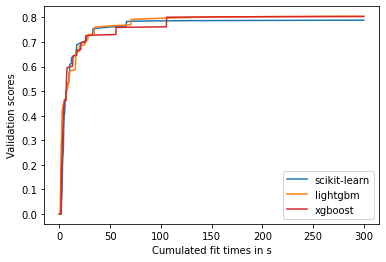

In [18]:
plt.plot(grid_times_skl, scores_skl, c='tab:blue', label="scikit-learn")
plt.plot(grid_times_lgbm, scores_lgbm, c='tab:orange', label="lightgbm")
plt.plot(grid_times_xgb, scores_xgb, c='tab:red', label="xgboost")

plt.xlabel("Cumulated fit times in s")
plt.ylabel("Validation scores")

plt.legend();